This notebook aims to discuss how to estimate the background NO2 over lightning NO2 pixels.

In [1]:
import numpy as np
import proplot as pplt
from satpy import Scene
import matplotlib.pyplot as plt
from glob import glob
import xarray as xr
from skued import baseline_dt, baseline_dwt

pplt.rc['cmap'] = 'viridis'
pplt.rc.update({'meta.width': 0.6, 'label.weight': 'bold', 'tick.labelweight': 'normal'})

## Read TROPOMI NO2 data

In [2]:
def load_tropomi(filename):
    """Load TROPOMI NO2 L2 products by satpy"""
    scn = Scene(filename, reader='tropomi_l2')
    vnames = ['cloud_radiance_fraction_nitrogendioxide_window', 'cloud_pressure_crb',
              'assembled_lat_bounds', 'assembled_lon_bounds',
              'longitude', 'latitude',
              'tm5_constant_a', 'tm5_constant_b', 'surface_pressure',
              'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_clear', 'air_mass_factor_cloudy',
              'oxygen_oxygen_dimer_slant_column_density',
              'nitrogendioxide_ghost_column', 'nitrogendioxide_tropospheric_column',
              'nitrogendioxide_slant_column_density', 'nitrogendioxide_stratospheric_column', 'air_mass_factor_stratosphere',
              'solar_zenith_angle', 'viewing_zenith_angle']

    if 'no2_vmr' in scn.available_dataset_names():
        vnames.append('no2_vmr')
        scn.load(vnames)
        scn['no2_vmr'] = scn['no2_vmr'].assign_coords({'longitude': scn['nitrogendioxide_tropospheric_column'].longitude})
    else:
        scn.load(vnames)

    scn['SCD_Strato'] = scn['nitrogendioxide_stratospheric_column'] * scn['air_mass_factor_stratosphere']
    scn['SCD_Trop'] = scn['nitrogendioxide_slant_column_density'] - scn['SCD_Strato']

    scn['SCD_Strato'] = scn['SCD_Strato'].rename('SCD_Strato')
    scn['SCD_Trop'] = scn['SCD_Trop'].rename('SCD_Trop')
    scn['SCD_Strato'].attrs['units'] = 'mol m-2'
    scn['SCD_Trop'].attrs['units'] = 'mol m-2'

    # calculate pressure levels
    a = scn['tm5_constant_a']
    b = scn['tm5_constant_b']
    psfc = scn['surface_pressure']

    low_p = (a[:, 0] + b[:, 0]*psfc)/1e2
    high_p = (a[:, 1] + b[:, 1]*psfc)/1e2

    scn['p'] = xr.concat([low_p, high_p.isel(layer=-1)], dim='layer')
    scn['p'] = scn['p'].rolling({'layer': 2}).mean()[1:, ...].load()
    scn['p'] = scn['p'].rename('tm5_pressure')
    scn['p'].attrs['units'] = 'hPa'

    # assign lon/lat coords
    scn['p'] = scn['p'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['solar_zenith_angle'] = scn['solar_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_clear'] = scn['air_mass_factor_clear'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_cloudy'] = scn['air_mass_factor_cloudy'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['nitrogendioxide_slant_column_density'] = scn['nitrogendioxide_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['viewing_zenith_angle'] = scn['viewing_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['oxygen_oxygen_dimer_slant_column_density'] = scn['oxygen_oxygen_dimer_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )

    return scn

In [3]:
scn_ltng = load_tropomi(glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190810T21*.nc'))
scn_noltng_before = load_tropomi(glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190809T21*.nc'))
scn_noltng_twoday_before = load_tropomi(glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190808T21*.nc'))
scn_noltng_after = load_tropomi(glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T21*.nc'))

scn_ltng_large = load_tropomi(glob('../data/tropomi/201906/S5P_PAL__L2__NO2____20190629T19*'))

Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/air_mass_factor_total
Can't load ancillary dataset /PRODUCT/averaging_kernel
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/cloud_selection_flag
Can't load ancillary dataset /PRODUCT/tm5_constant_a
Can't load ancillary dataset /PRODUCT/tm5_constant_b
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/cloud_pressure_crb
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/tm5_tropopause_layer_index
Can't load anci

## Overview of TROPOMI data

### Cloud

In [4]:
def plot_cld(scn, axs):
    mask = (scn['longitude'] >= 90) & (scn['longitude'] <= 140) & \
            (scn['latitude'] >= 82) & (scn['latitude'] <=87)

    scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[0],
                cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                )

    (scn['cloud_pressure_crb']/1e2).where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[1],
                cmap='Blues', vmin=100, vmax=1e3, discrete=False)

    scn['cloud_radiance_fraction_nitrogendioxide_window'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[2],
                cmap='Blues_r', vmin=0, vmax=1, discrete=False)

    scn['solar_zenith_angle'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[3],
                cmap='Thermal', vmin=68, vmax=76, discrete=False)

In [ ]:
fig, axs = pplt.subplots(nrows=3, ncols=4)

plot_cld(scn_noltng_before, axs[:4])
plot_cld(scn_ltng, axs[4:8])
plot_cld(scn_noltng_after, axs[8:])

axs.format(xlim=(90, 140), ylim=(82, 87),
           xlabel='Longitude', ylabel='Latitude', title='',
        # xticks=[], yticks=[], xlabel='', ylabel='', title='',
          toplabels=['NO2 VCD', 'CP', 'CRF', 'SZA'],
          leftlabels=['no lightning case (day0)',
                     'lightning case (day1)',
                     'no lightning case (day2)'],
                     facecolor='Gray')

## Air mass factors

In [6]:
def plot_amf(scn, axs):
    mask = (scn['longitude'] >= 90) & (scn['longitude'] <= 140) & \
            (scn['latitude'] >= 82) & (scn['latitude'] <=87)

    scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[0],
                cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                )

    scn['air_mass_factor_troposphere'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[1],
                cmap='Thermal', vmin=0.5, vmax=4, discrete=False)

    scn['air_mass_factor_clear'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[2],
                cmap='Thermal', vmin=3, vmax=4, discrete=False)

    scn['air_mass_factor_cloudy'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[3],
                cmap='Thermal', vmin=0.5, vmax=4, discrete=False)

In [ ]:
fig, axs = pplt.subplots(nrows=3, ncols=4)

plot_amf(scn_noltng_before, axs[:4])
plot_amf(scn_ltng, axs[4:8])
plot_amf(scn_noltng_after, axs[8:])

axs.format(xlim=(90, 140), ylim=(82, 87),
           xlabel='Longitude', ylabel='Latitude', title='',
        # xticks=[], yticks=[], xlabel='', ylabel='', title='',
          toplabels=['NO2 VCD', 'AMF_Trop', 'AMF_Clr', 'AMF_Cld'],
          leftlabels=['no lightning case (day0)',
                     'lightning case (day1)',
                     'no lightning case (day2)'],
                     facecolor='Gray')

## Slant column density

In [8]:
def plot_scd(scn, axs):
    mask = (scn['longitude'] >= 90) & (scn['longitude'] <= 140) & \
            (scn['latitude'] >= 82) & (scn['latitude'] <=87)

    scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[0],
                cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                )

    scn['SCD_Trop'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[1],
                cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-4.5e-5, vmax=4.5e-5, discrete=False,
                )

    scn['SCD_Strato'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[2],
                cmap='Thermal', vmin=2.5e-4, vmax=4e-4, discrete=False,
                )


    scn['nitrogendioxide_slant_column_density'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[3],
                cmap='Thermal', vmin=2.5e-4, vmax=4e-4, discrete=False,
                )


#     scn['viewing_zenith_angle'].where(mask, drop=True).plot(
#                 x='longitude', y='latitude', ax=axs[3],
#                 cmap='Thermal', vmin=5, vmax=45, discrete=False)

In [ ]:
fig, axs = pplt.subplots(nrows=3, ncols=4)

plot_scd(scn_noltng_before, axs[:4])
plot_scd(scn_ltng, axs[4:8])
plot_scd(scn_noltng_after, axs[8:])

axs.format(xlim=(90, 140), ylim=(82, 87),
           xlabel='Longitude', ylabel='Latitude', title='',
        # xticks=[], yticks=[], xlabel='', ylabel='', title='',
          toplabels=['NO2 VCD', 'SCD_Trop', 'SCD_Strato', 'SCD_Total'],
          leftlabels=['no lightning case (day0)',
                     'lightning case (day1)',
                     'no lightning case (day2)'],
                     facecolor='Gray')

## TM5 a priori profile

Note that the cell below needs the extraction of TM5 profiles for the TROPOMI NO2 L2 files.

The full tutorial is available [here](https://sentinel.esa.int/documents/247904/2474726/PUM-for-the-TM5-NO2-SO2-and-HCHO-profile-auxiliary-support-product.pdf/de18a67f-feca-1424-0195-756c5a3df8df).

Check the TM5 profile at the high NO2 pixel

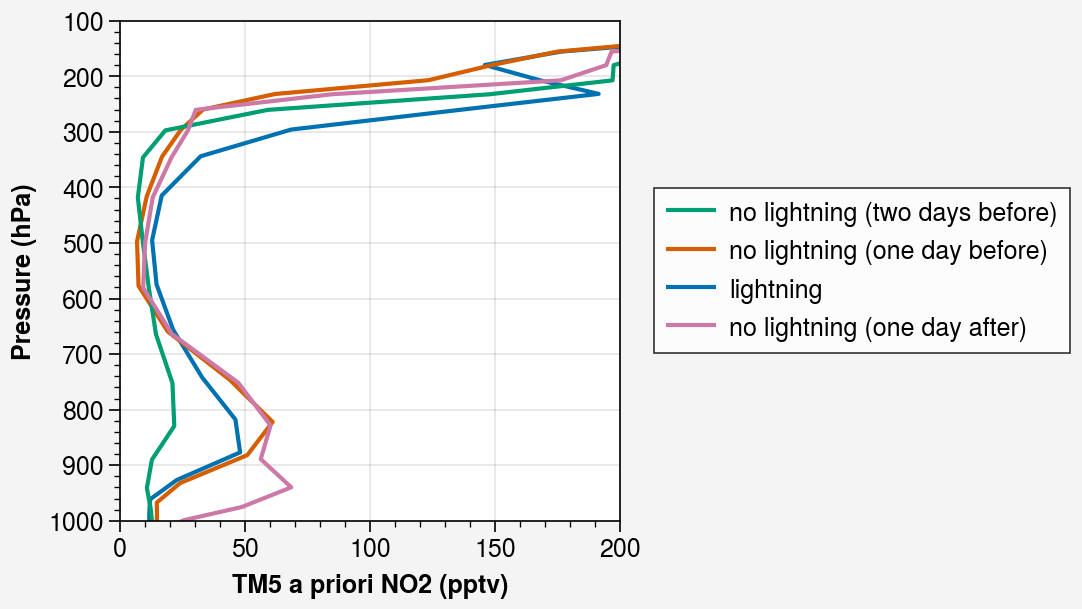

In [10]:
fig, axs = pplt.subplots()

l_ltng = axs.plot(scn_ltng['no2_vmr'].sel(x=310, y=3552)*1e12, scn_ltng['p'].sel(x=310, y=3552), label='lightning')
l_noltng_before = axs.plot(scn_noltng_before['no2_vmr'].sel(x=306, y=3537)*1e12, scn_noltng_before['p'].sel(x=306, y=3537), label='no lightning (one day before)')

l_noltng_twodays_before = axs.plot(scn_noltng_twoday_before['no2_vmr'].sel(x=303, y=3520)*1e12, scn_noltng_twoday_before['p'].sel(x=303, y=3520), label='no lightning (two days before)')

l_noltng_after = axs.plot(scn_noltng_after['no2_vmr'].sel(x=315, y=3568)*1e12, scn_noltng_after['p'].sel(x=315, y=3568), label='no lightning (one day after)')


axs.legend([l_noltng_twodays_before, l_noltng_before, l_ltng, l_noltng_after], loc='r', ncols=1)
axs.format(xlabel='TM5 a priori NO2 (pptv)', ylabel='Pressure (hPa)', ylim=(1000, 100), xlim=(0, 200))

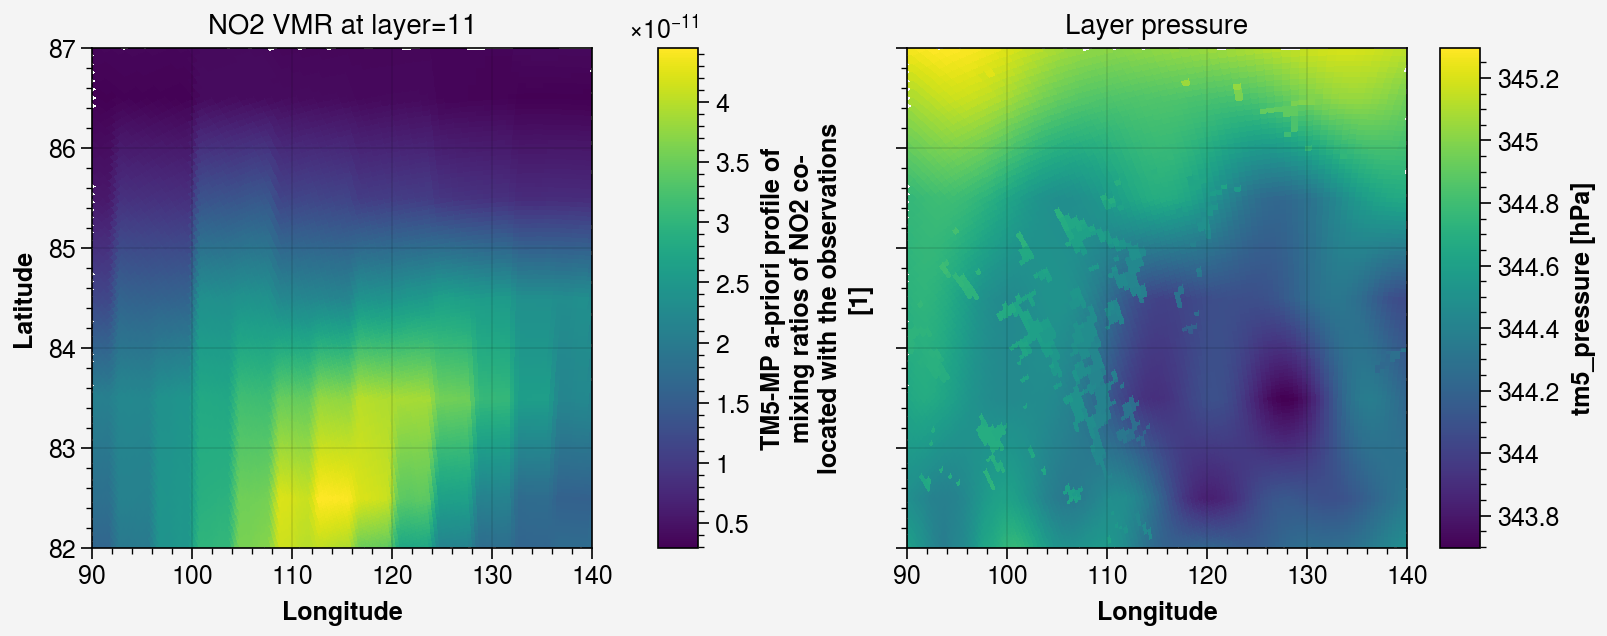

In [11]:
# Check the horizontal distribution of TM5 a priori profile near 300 hPa

mask = (scn_ltng['longitude'] >= 90) & (scn_ltng['longitude'] <= 140) & \
        (scn_ltng['latitude'] >= 82) & (scn_ltng['latitude'] <=87)

fig, axs = pplt.subplots(ncols=2, span=0)

ax = axs[0]
scn_ltng['no2_vmr'].isel(layer=11).where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude', discrete=False)
ax.format(title='NO2 VMR at layer=11')

ax = axs[1]
scn_ltng['p'].isel(layer=11).where(mask, drop=True).plot(ax=ax, x='longitude', y='latitude', discrete=False)
ax.format(title='Layer pressure')

axs.format(xlim=(90, 140), ylim=(82, 87), xlabel='Longitude', ylabel='Latitude')

It seems the a priori profile only assimilates the lightning NO2 above the cloud,
because the lightning NO2 usually has two peaks (Ott et al. 2010):

![LNO2_profile](https://github.com/zxdawn/S5P-LNO2-Notebook/blob/main/analysis/imgs/Ott_2010.png)

As mentioned by Folkert Boersma et al. (2005):

> Ghost column difficulties occur in situations when clouds screen the lower part of the atmosphere and the retrieved total column comes to depend heavily on the assumptions on the lower, unseen part.

![averaging_vernel](https://github.com/zxdawn/S5P-LNO2-Notebook/blob/main/analysis/imgs/Boersma_2005.png)

And the sensitivity test of S. Beirle et al. (2009) explains it in detail:

![sensitivity](https://github.com/zxdawn/S5P-LNO2-Notebook/blob/main/analysis/imgs/Beirle_2009.png)

So, we need to keep this in mind: the NO2 VCD may not include all LNO2 signals, expecially under the cloud.


## Relationship among SZA, VZA, and SCD

In [12]:
def plot_relation(scn, plot_var, xlabel, xlim, ylim, ax):
    s = ax.scatter(plot_var.sel(x=xlim, y=ylim).stack(z=['x','y']),
                scn['solar_zenith_angle'].sel(x=xlim, y=ylim).stack(z=['x','y']),
                c=scn['viewing_zenith_angle'].sel(x=xlim, y=ylim).stack(z=['x','y']),
                s=1, cmap='viridis')

    ax.format(xlabel=xlabel)

    return s

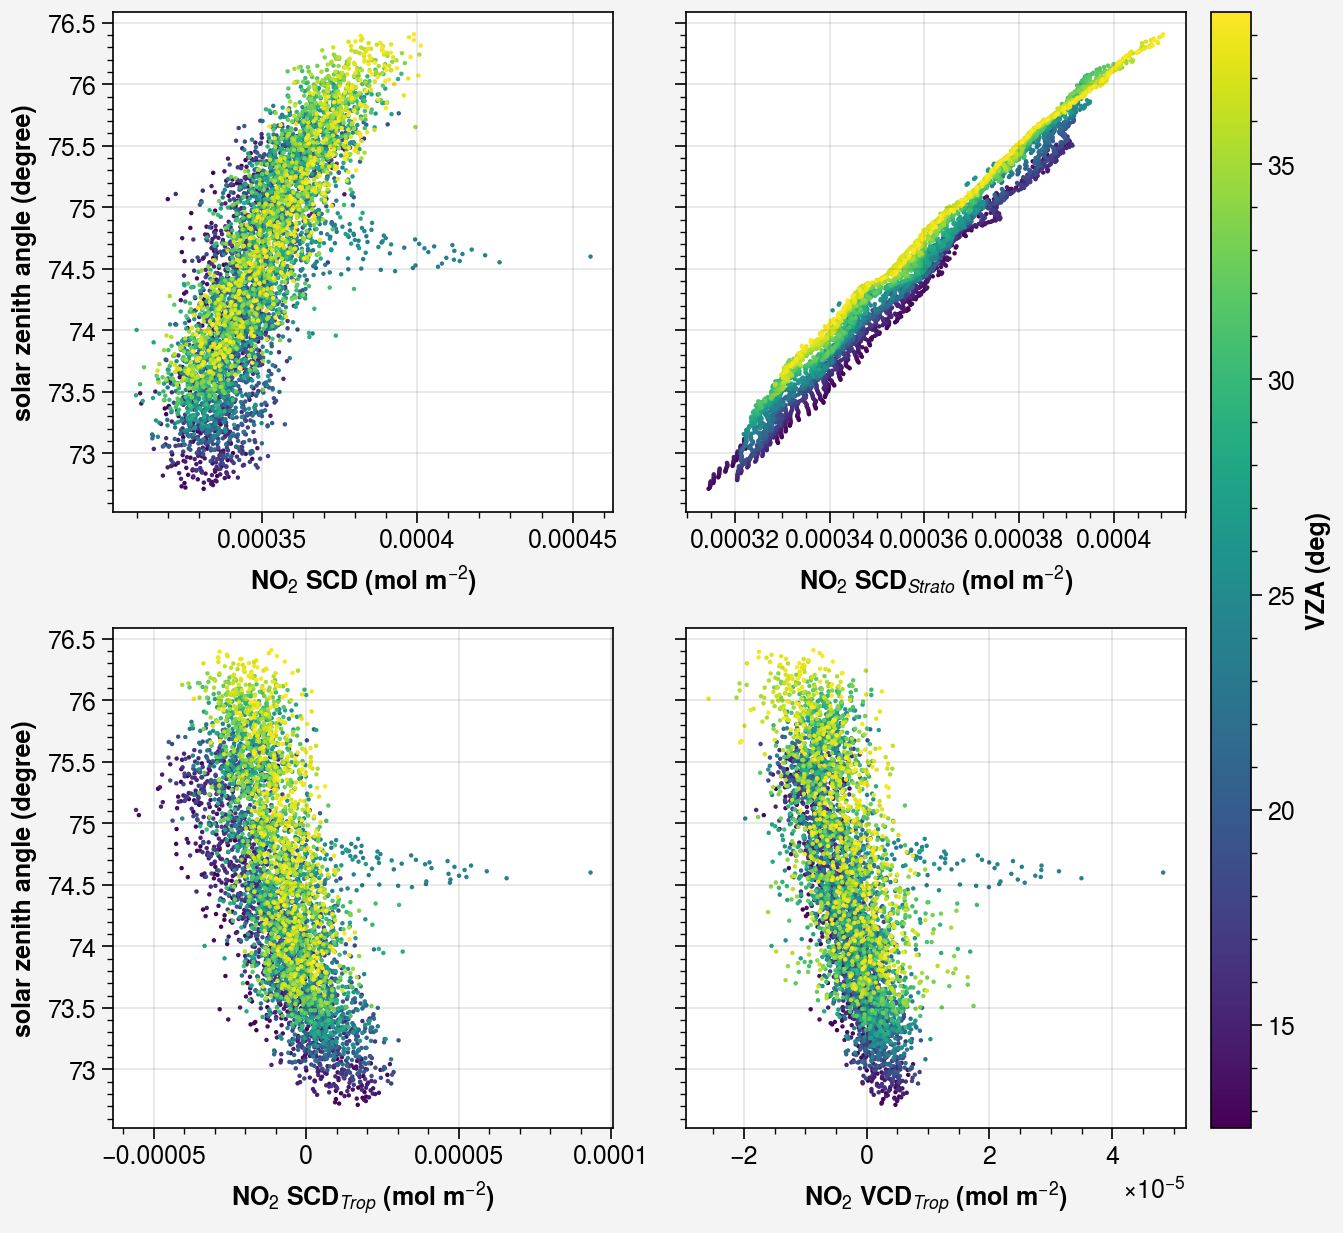

In [13]:
fig, axs = pplt.subplots(nrows=2, ncols=2, sharex=0, sharey=3, spany=0)

xlim=slice(270, 360)
ylim=slice(3520, 3580)

plot_relation(scn_ltng, scn_ltng['nitrogendioxide_slant_column_density'],
              xlabel='NO$_2$ SCD (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[0])

plot_relation(scn_ltng, scn_ltng['SCD_Strato'],
              xlabel='NO$_2$ SCD$_{Strato}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[1])

plot_relation(scn_ltng, scn_ltng['SCD_Trop'],
              xlabel='NO$_2$ SCD$_{Trop}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[2])

s = plot_relation(scn_ltng, scn_ltng['nitrogendioxide_tropospheric_column'],
              xlabel='NO$_2$ VCD$_{Trop}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[3])

fig.colorbar([s], loc='r', label='VZA (deg)')

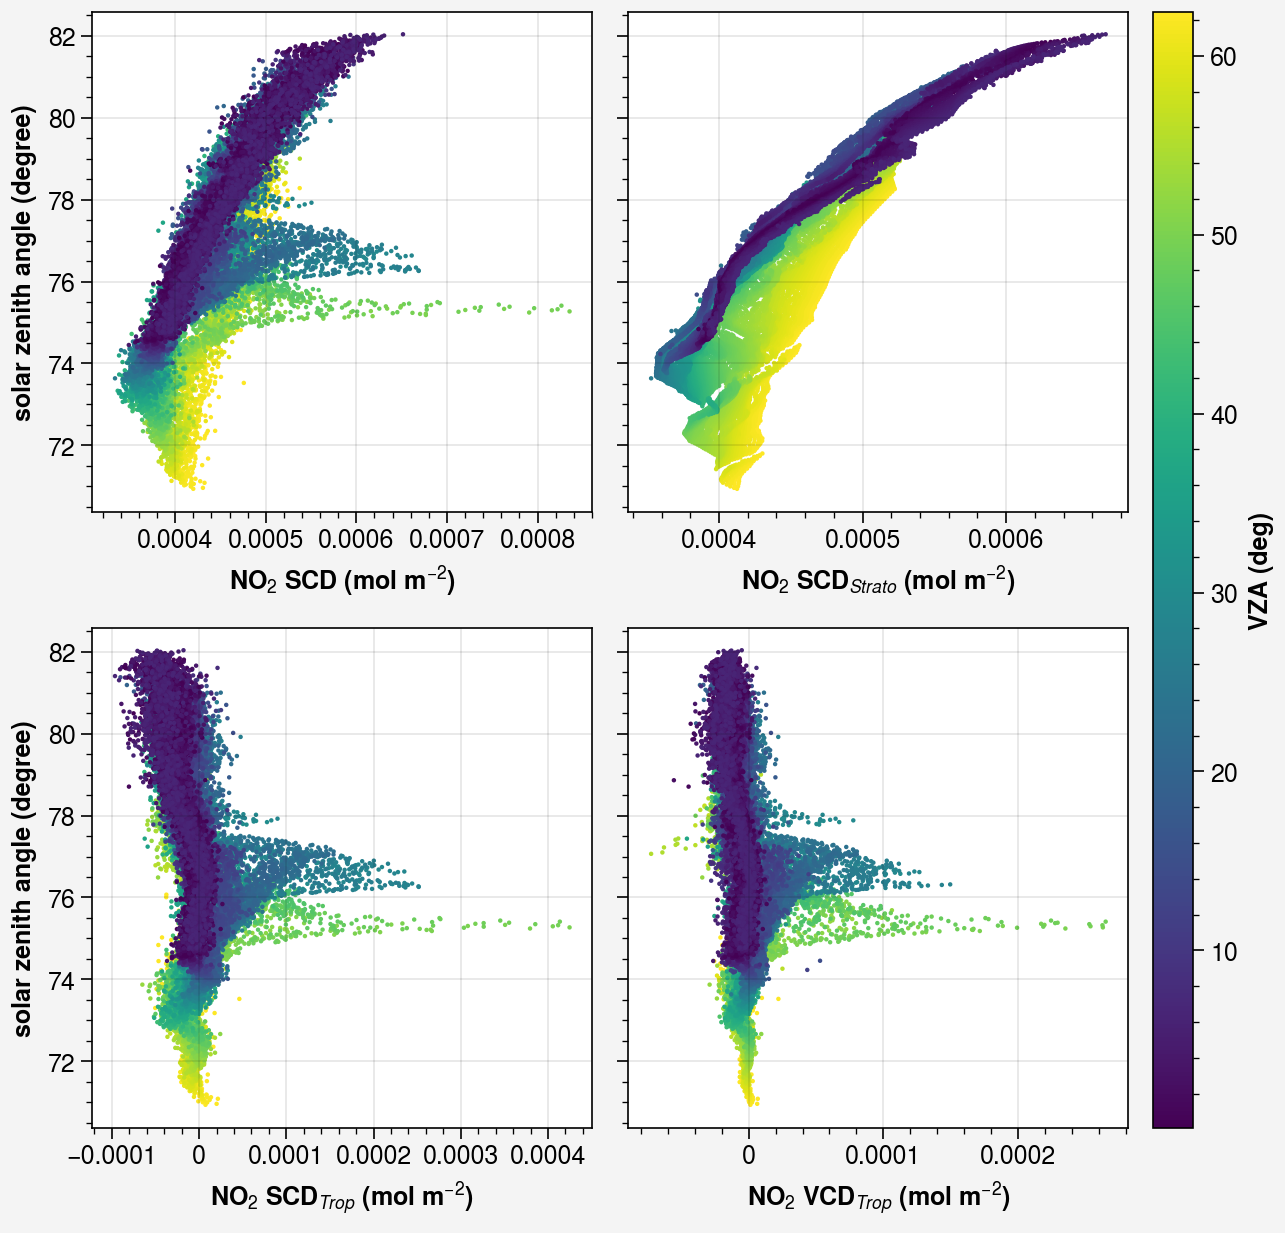

In [14]:
fig, axs = pplt.subplots(nrows=2, ncols=2, sharex=0, sharey=3, spany=0)

xlim=slice(20, 250)
ylim=slice(2780, 2900)

plot_relation(scn_ltng_large, scn_ltng_large['nitrogendioxide_slant_column_density'],
              xlabel='NO$_2$ SCD (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[0])

plot_relation(scn_ltng_large, scn_ltng_large['SCD_Strato'],
              xlabel='NO$_2$ SCD$_{Strato}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[1])

plot_relation(scn_ltng_large, scn_ltng_large['SCD_Trop'],
              xlabel='NO$_2$ SCD$_{Trop}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[2])

s = plot_relation(scn_ltng_large, scn_ltng_large['nitrogendioxide_tropospheric_column'],
              xlabel='NO$_2$ VCD$_{Trop}$ (mol m$^{-2}$)',
              xlim=xlim, ylim=ylim, ax=axs[3])

fig.colorbar([s], loc='r', label='VZA (deg)')

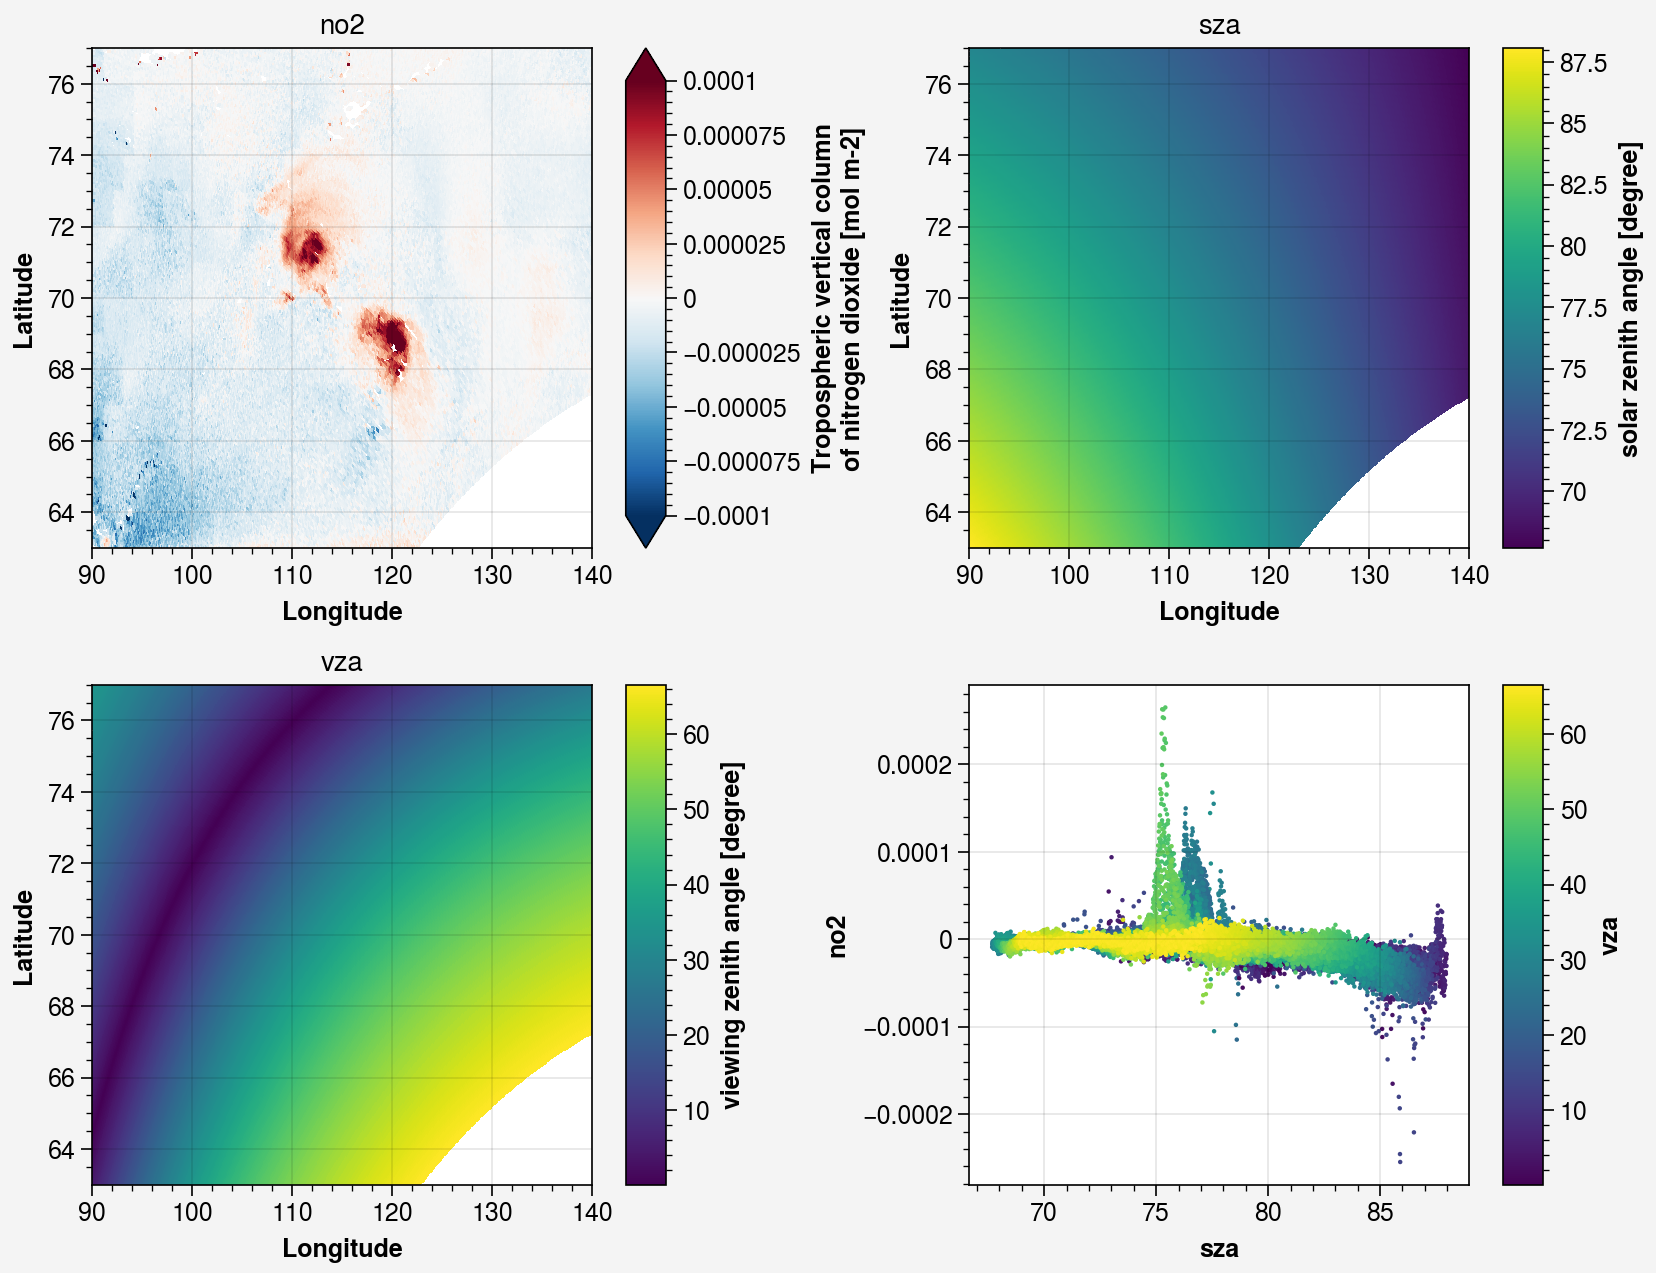

In [15]:
fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

mask = (scn_ltng_large['longitude'] >= 90) & (scn_ltng_large['longitude'] <= 140) & \
        (scn_ltng_large['latitude'] >= 63) & (scn_ltng_large['latitude'] <=77)

sza = scn_ltng_large['solar_zenith_angle'].where(mask, drop=True)
vza = scn_ltng_large['viewing_zenith_angle'].where(mask, drop=True)
no2 = scn_ltng_large['nitrogendioxide_tropospheric_column'].where(mask, drop=True)

# sza = scn_ltng_large['solar_zenith_angle'].sel(x=slice(0, 250), y=slice(2750, 2900))
# vza = scn_ltng_large['viewing_zenith_angle'].sel(x=slice(0, 250), y=slice(2750, 2900))
# # no2 = scn_ltng_large['nitrogendioxide_slant_column_density'].sel(x=slice(0, 250), y=slice(2750, 2900))
# no2 = scn_ltng_large['nitrogendioxide_tropospheric_column'].sel(x=slice(0, 250), y=slice(2750, 2900))

no2.plot(x='longitude', y='latitude', ax=axs[0], discrete=False, vmin=-1e-4)
axs[0].format(title='no2')

sza.plot(x='longitude', y='latitude', ax=axs[1], discrete=False)
axs[1].format(title='sza')

vza.plot(x='longitude', y='latitude', ax=axs[2], discrete=False)
axs[2].format(title='vza')

s = axs[3].scatter(sza.stack(z=['y', 'x']), no2.stack(z=['y', 'x']), c=vza.stack(z=['y', 'x']), s=1)
plt.colorbar(s, ax=axs[3], label='vza')
axs[3].format(xlabel='sza', ylabel='no2')

axs[:3].format(xlabel='Longitude', ylabel='Latitude', xlim=(90, 140), ylim=(63, 77))

The peaks of NO2 are obvious in SCD, SCD_Trop, and VCD_Trop. 

Because the peaks of SCD and VCD may not coincide well each other,
it is better to calculate the baseline of VCD_Trop.

We come up with two methods:

1. Iterating the vza bins and fit the 1D baseline of NO2 VCD
2. Dierectly get the 2D baseline of NO2 VCD

## Estimating background NO2

### Method 1 (1D baseline)

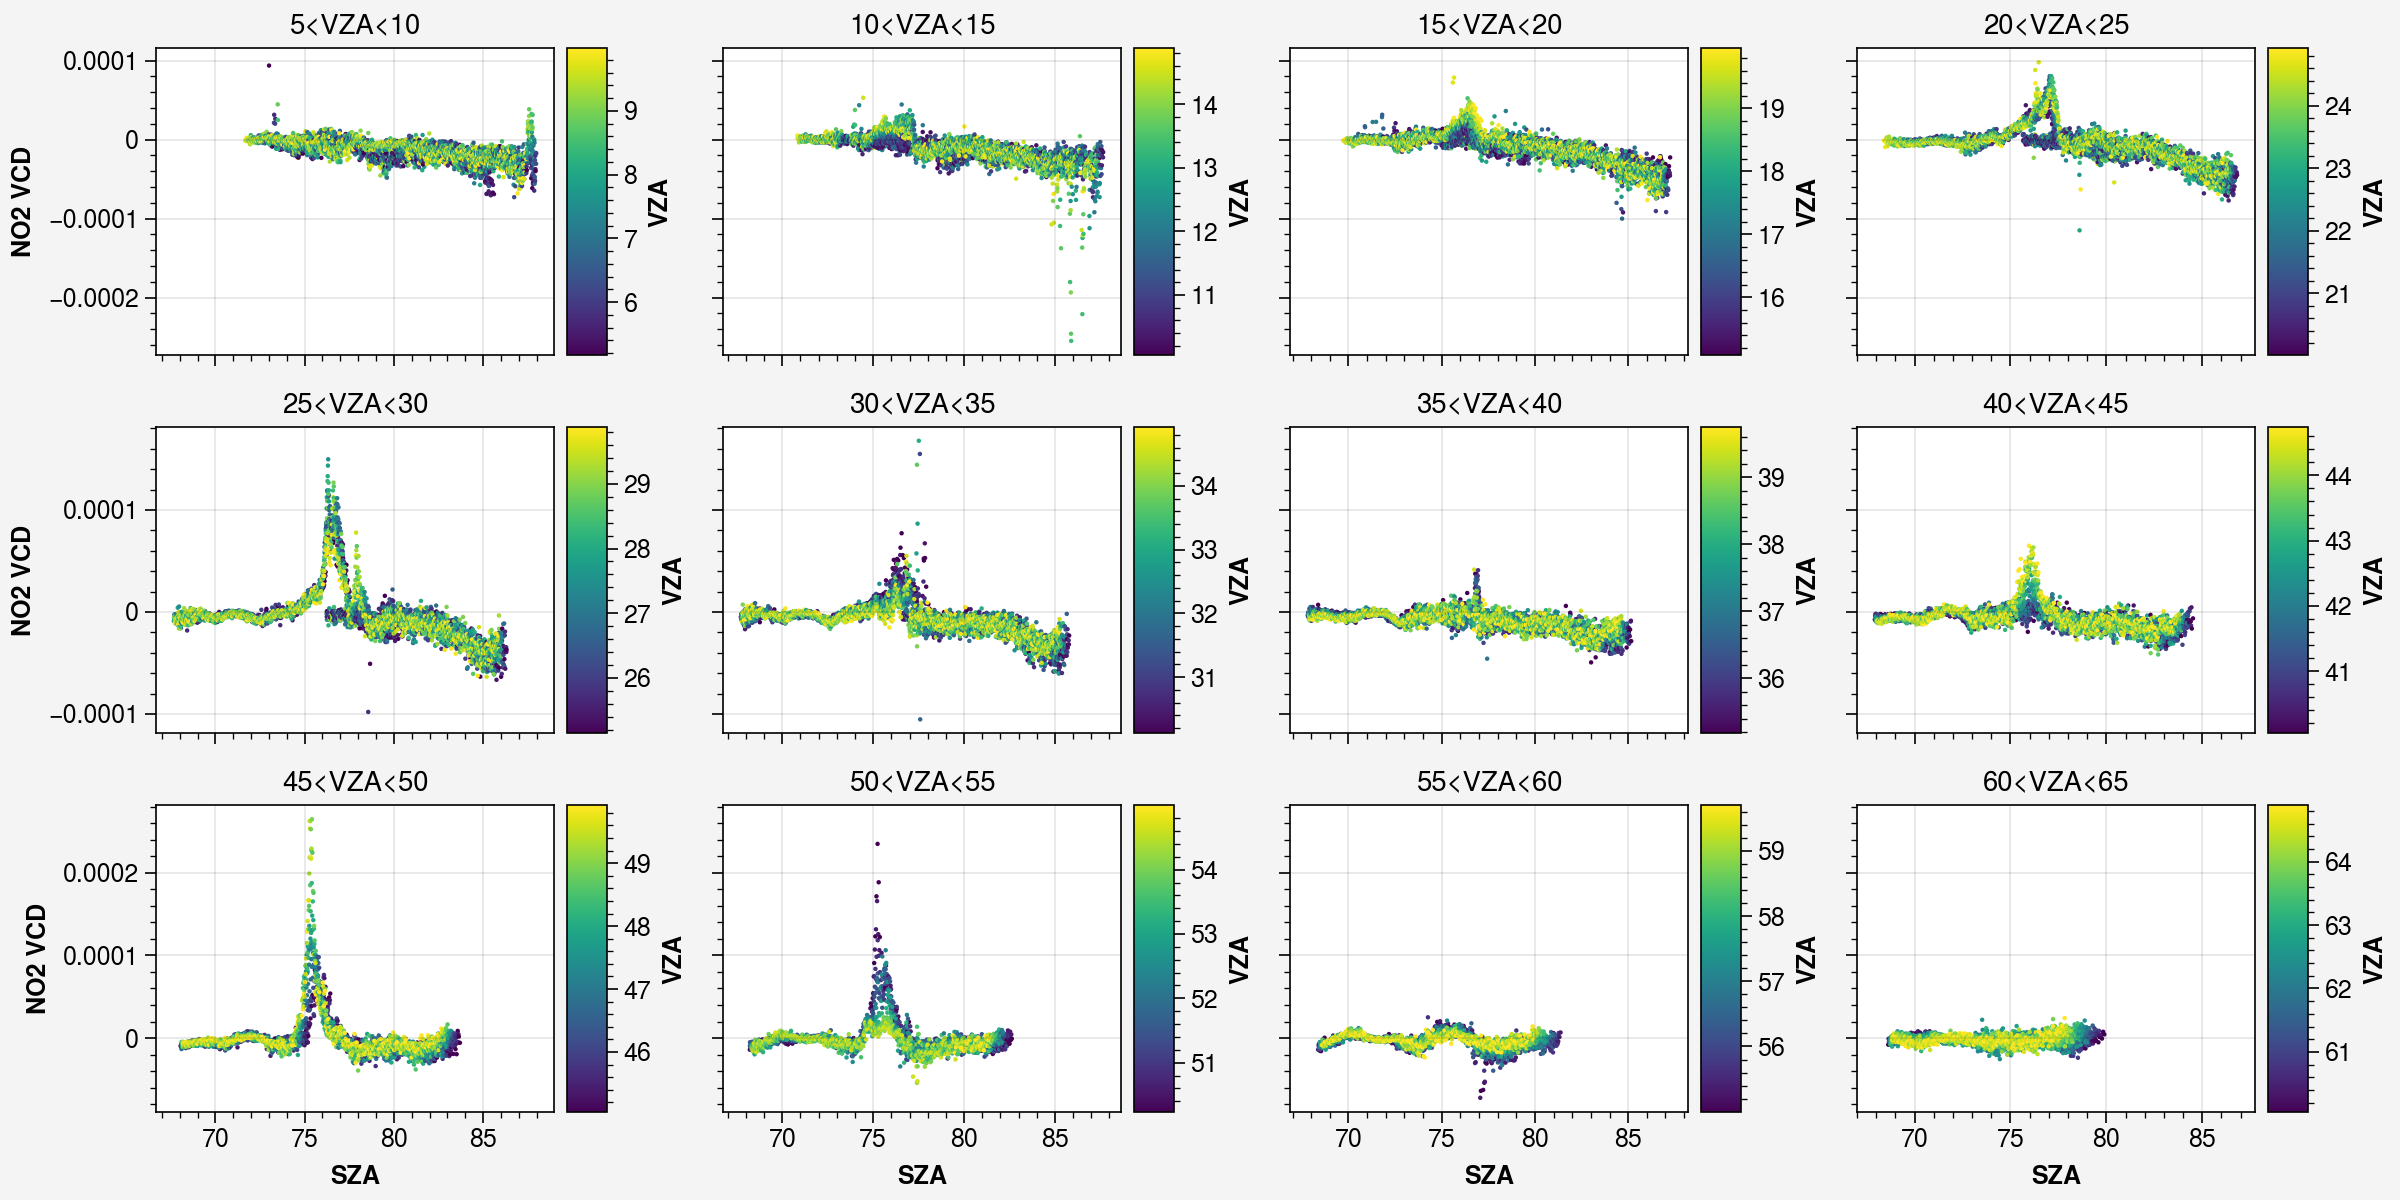

In [16]:
fig, axs = pplt.subplots(nrows=3, ncols=4, spanx=0, spany=0, figsize=(12, 6))

for index,bin in enumerate(range(5, 65, 5)):
    mask = (vza>bin)&(vza<bin+5)
    s = axs[index].scatter(sza.where(mask).stack(z=['y', 'x']),
                           no2.where(mask).stack(z=['y', 'x']),
                           c=vza.where(mask).stack(z=['y', 'x']),
                           s=1)
    axs[index].colorbar(s, label='VZA')
    axs[index].set_title(str(bin)+'<VZA<'+str(bin+5))

axs.format(xlabel='SZA', ylabel='NO2 VCD')

We can use arPLS by [rampy](https://github.com/charlesll/rampy/blob/master/examples/Baseline.ipynb) to fit the baseline for each VZA bin.

However, that will cost much time. So, we swtich to the second Method_2.

### Method 2 (2D baseline)

We follows the tutorial [here](https://scikit-ued.readthedocs.io/en/master/tutorials/baseline.html) using [scikit-ued
](https://github.com/LaurentRDC/scikit-ued) which supports both 1D and 2D data.

In [17]:
baseline = baseline_dt(no2, wavelet = 'qshift3', level = 6, max_iter = 150)
np.all(np.isnan(baseline))

True

Well, if there're any nan values, `baseline_dt` will return empty array.

Let's assign the nan by 0 to test the function first.

/tmp/ipykernel_29922/1123737810.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


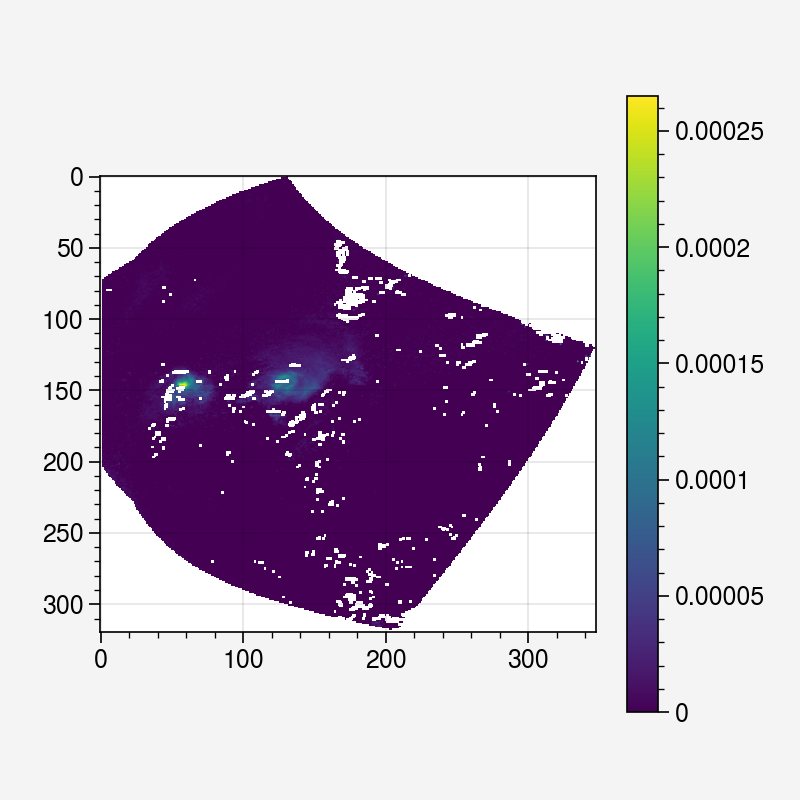

In [18]:
baseline_0 = baseline_dt(np.nan_to_num(no2, nan=0), wavelet = 'qshift3', level = 6, max_iter = 150)
plt.imshow(no2-baseline_0)
plt.colorbar()

Nice! The baseline is mostly zero for non-lightning pixels.

Let's dig deeper of the baseline function.

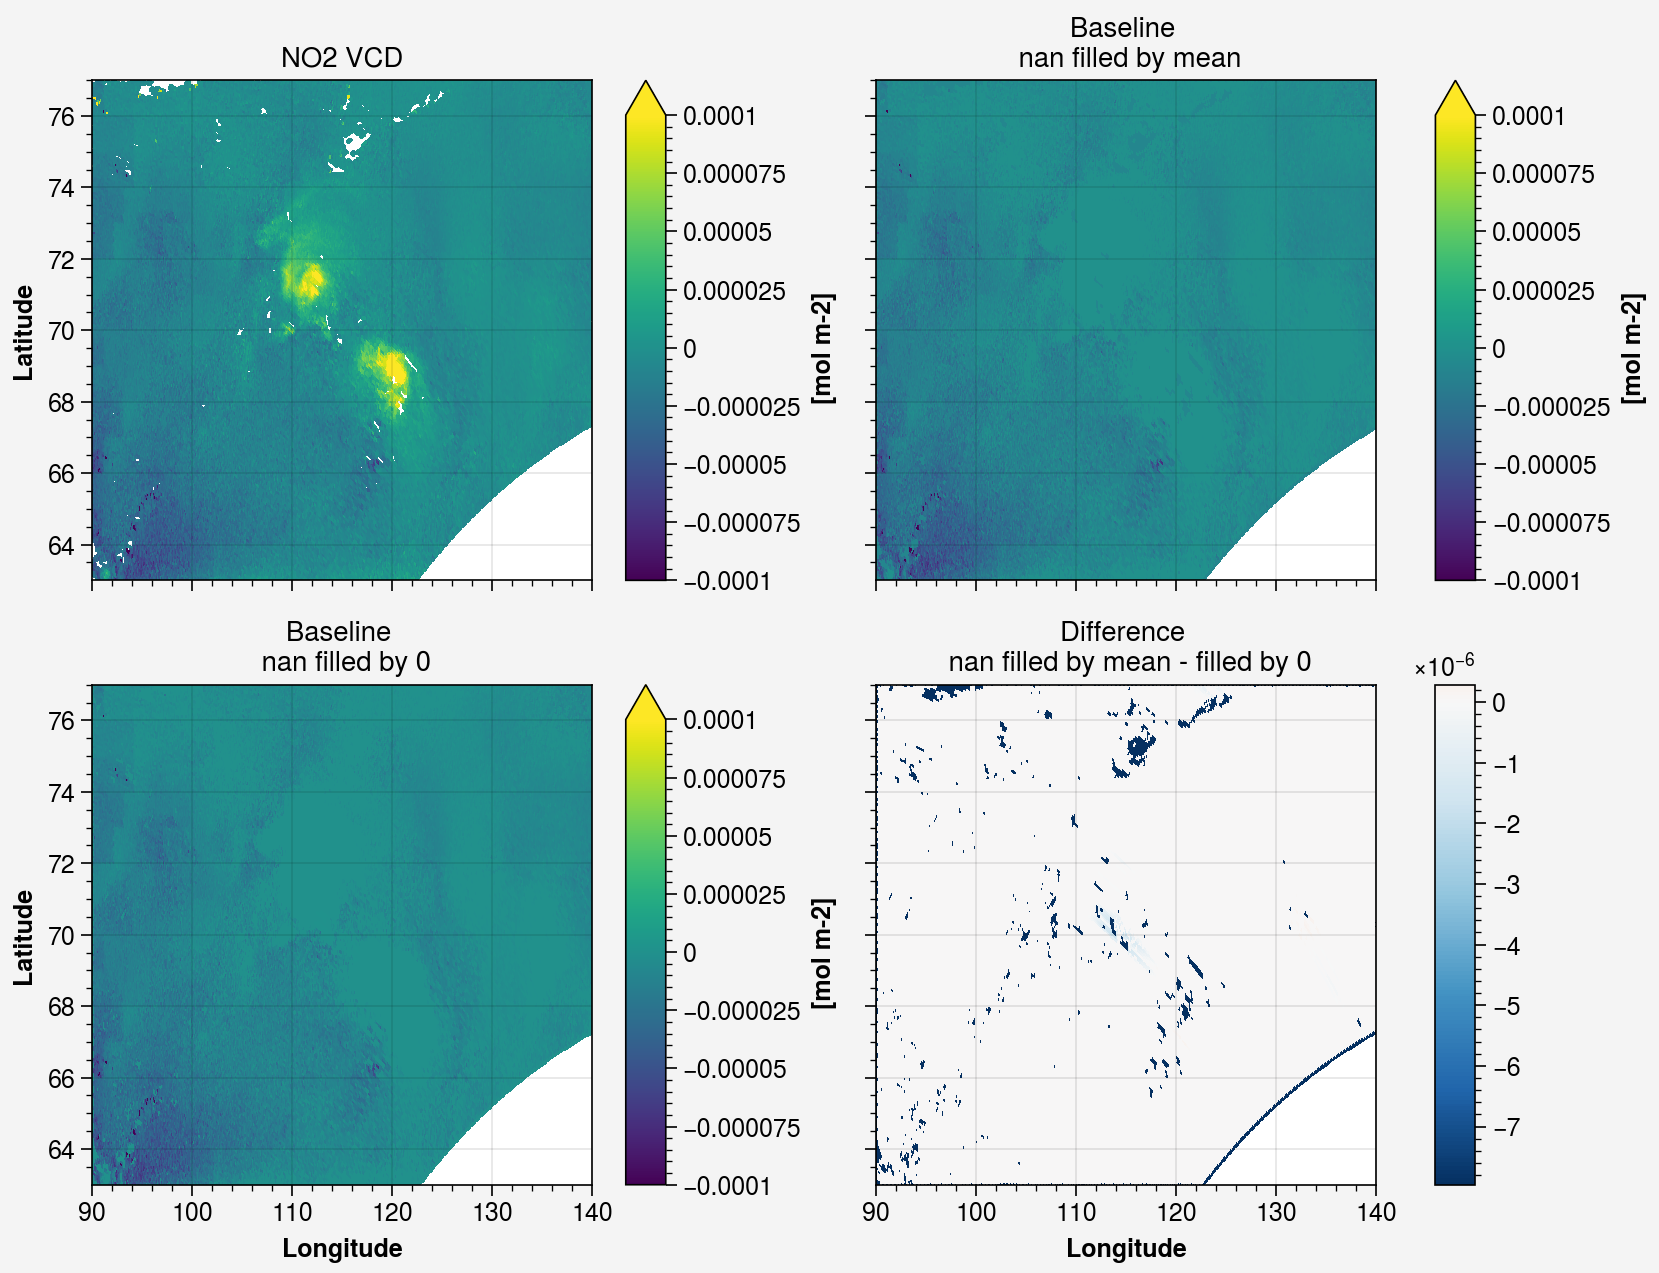

In [19]:
# replace the nan values by mean no2 
baseline_mean = baseline_dt(np.nan_to_num(no2, nan=np.nanmean(no2)), wavelet = 'qshift3', level = 6, max_iter = 150)

fig, axs = pplt.subplots(nrows=2, ncols=2, spanx=0, spany=0)

lon, lat = no2.longitude, no2.latitude

m = axs[0].pcolormesh(lon, lat, no2, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[0].colorbar([m], label='[mol m-2]', extend='max')
axs[0].format(title='NO2 VCD')

m = axs[1].pcolormesh(lon, lat, baseline_mean, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[1].colorbar([m], label='[mol m-2]', extend='max')
axs[1].format(title='Baseline \n nan filled by mean')

m = axs[2].pcolormesh(lon, lat, baseline_0, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[2].colorbar([m], label='[mol m-2]', extend='max')
axs[2].format(title='Baseline \n nan filled by 0')

m = axs[3].pcolormesh(lon, lat, baseline_mean-baseline_0, discrete=False)
axs[3].colorbar([m])
axs[3].format(title='Difference \n nan filled by mean - filled by 0')

axs.format(xlabel='Longitude', ylabel='Latitude', xlim=(90, 140), ylim=(63, 77))

The difference is quite small for the changed fill_value of nan and they are all in the pixels of missing value.

Let's test other parameters with the mean values as nan.

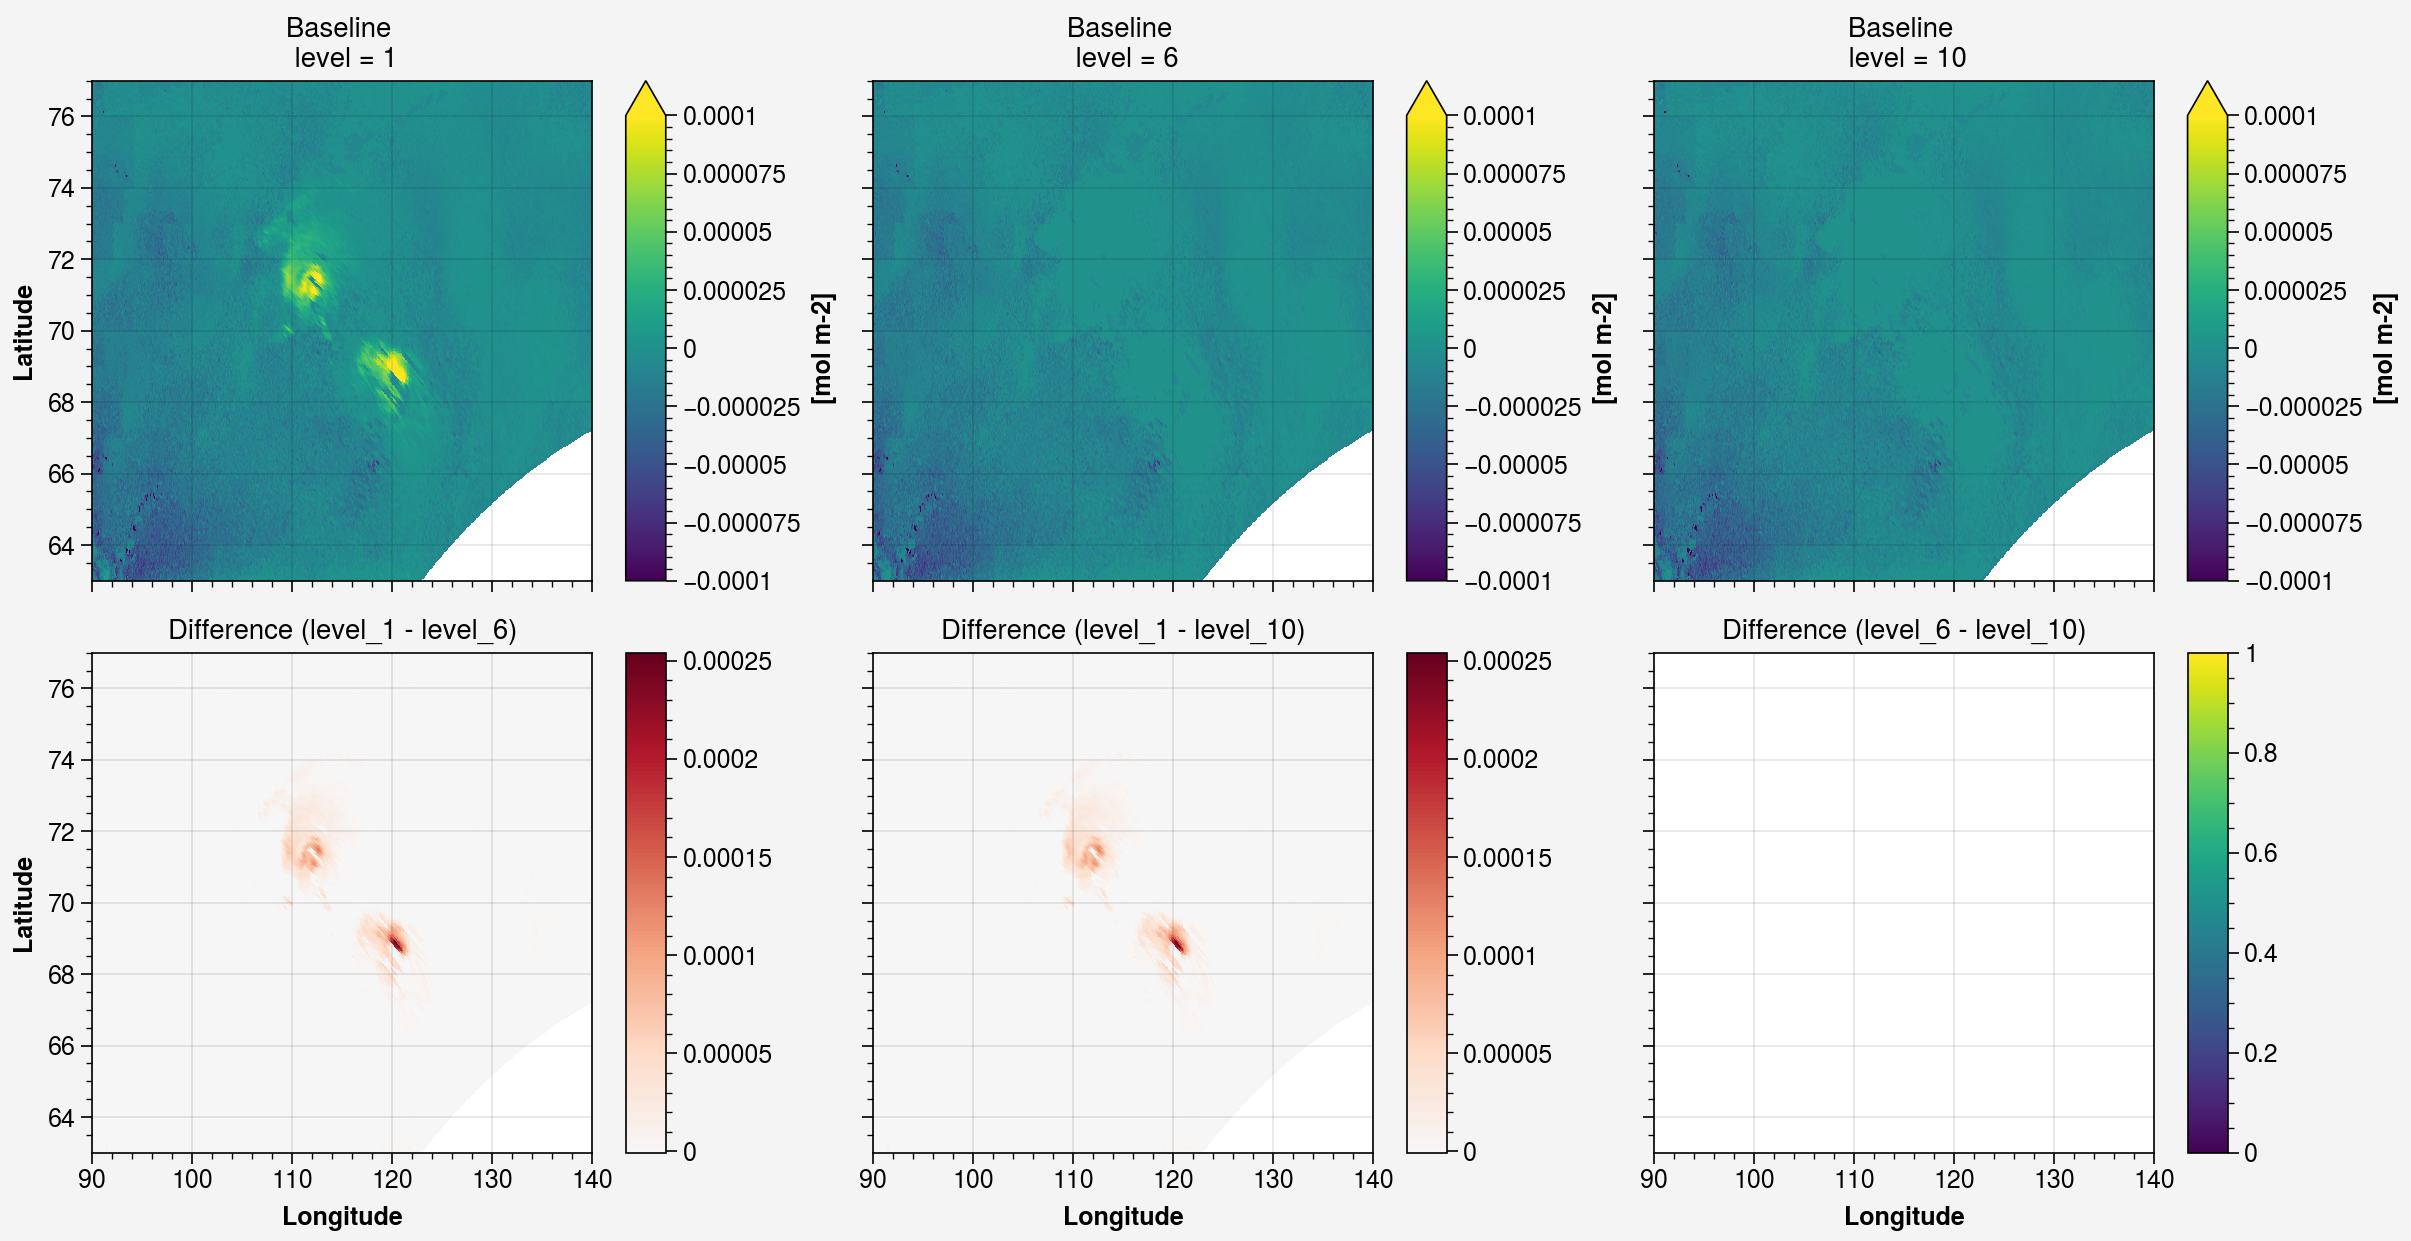

In [20]:
baseline_default = baseline_dt(np.nan_to_num(no2, nan=np.nanmean(no2)), wavelet = 'qshift3', level = 6, max_iter = 150)
baseline_lowlevel = baseline_dt(np.nan_to_num(no2, nan=np.nanmean(no2)), wavelet = 'qshift3', level=1, max_iter = 150)
baseline_highlevel = baseline_dt(np.nan_to_num(no2, nan=np.nanmean(no2)), wavelet = 'qshift3', level=10, max_iter = 150)

fig, axs = pplt.subplots(nrows=2, ncols=3, spanx=0, spany=0)

lon, lat = no2.longitude, no2.latitude

m = axs[0].pcolormesh(lon, lat, baseline_lowlevel, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[0].colorbar([m], label='[mol m-2]', extend='max')
axs[0].format(title='Baseline \n level = 1')

m = axs[1].pcolormesh(lon, lat, baseline_default, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[1].colorbar([m], label='[mol m-2]', extend='max')
axs[1].format(title='Baseline \n level = 6')

m = axs[2].pcolormesh(lon, lat, baseline_highlevel, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='viridis')
axs[2].colorbar([m], label='[mol m-2]', extend='max')
axs[2].format(title='Baseline \n level = 10')

m = axs[3].pcolormesh(lon, lat, baseline_lowlevel-baseline_default, discrete=False)
axs[3].colorbar([m])
axs[3].format(title='Difference (level_1 - level_6)')

m = axs[4].pcolormesh(lon, lat, baseline_lowlevel-baseline_default, discrete=False)
axs[4].colorbar([m])
axs[4].format(title='Difference (level_1 - level_10)')

m = axs[5].pcolormesh(lon, lat, baseline-baseline_highlevel, discrete=False)
axs[5].colorbar([m])
axs[5].format(title='Difference (level_6 - level_10)')

axs.format(xlabel='Longitude', ylabel='Latitude', xlim=(90, 140), ylim=(63, 77))

It seems `level=10` is a good option: coarse enough and almost similar with `level=6`.

### Results

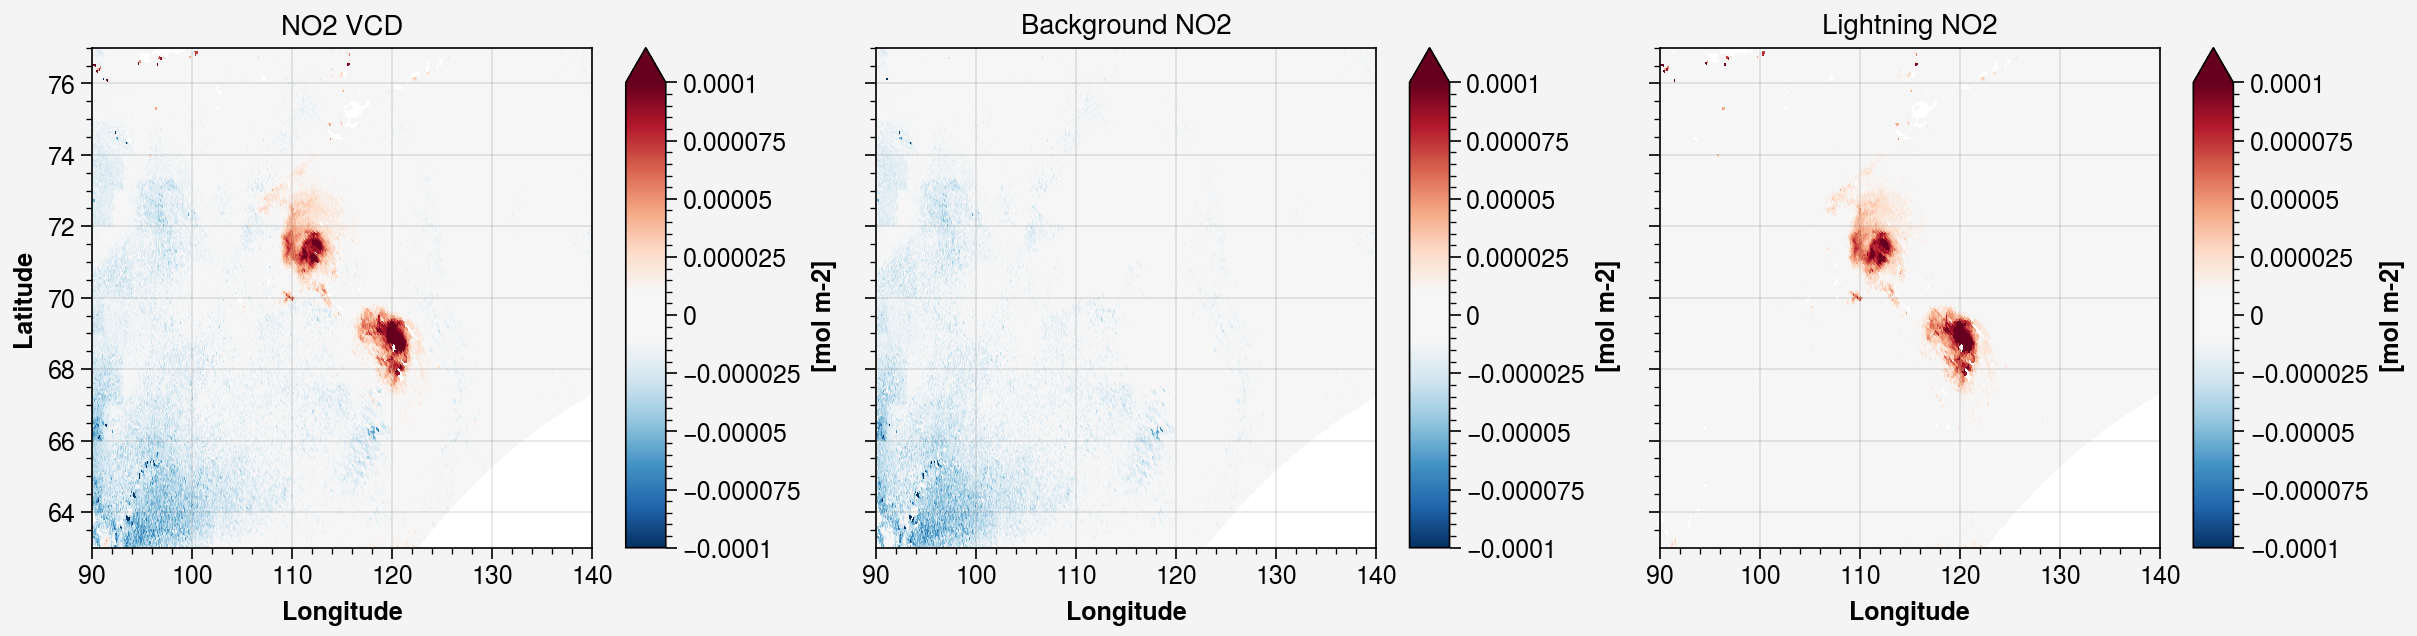

In [21]:
baseline = baseline_dt(np.nan_to_num(no2, nan=np.nanmean(no2)), wavelet = 'qshift3', level=10, max_iter = 150)

fig, axs = pplt.subplots(ncols=3, spanx=0, spany=0)

lon, lat = no2.longitude, no2.latitude

m = axs[0].pcolormesh(lon, lat, no2, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[0].colorbar([m], label='[mol m-2]', extend='max')
axs[0].format(title='NO2 VCD')

m = axs[1].pcolormesh(lon, lat, baseline, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[1].colorbar([m], label='[mol m-2]', extend='max')
axs[1].format(title='Background NO2')

m = axs[2].pcolormesh(lon, lat, no2-baseline, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[2].colorbar([m], label='[mol m-2]', extend='max')
axs[2].format(title='Lightning NO2')

axs.format(xlabel='Longitude', ylabel='Latitude', xlim=(90, 140), ylim=(63, 77))

BTW, the `baseline_dt` only works for 1D data according to the [guide](https://scikit-ued.readthedocs.io/en/master/functions/skued.baseline_dt.html#skued.baseline_dt):

> Iterative method of baseline-determination based on the dual-tree complex wavelet transform. This function only works in 1D, along an axis. For baseline of 2D arrays, see baseline_dwt().

However, `baseline_dwt()` doesn't work in our lightning NO2 case.

Maybe, they updated the function and forgot to update the DOC. Please see the [issue](https://github.com/LaurentRDC/scikit-ued/issues/37) we created.

We also find some other useful methods of estimating the baseline, in case users are interested:

- [Baseline Estimation And Denoising with Sparsity](http://www.laurent-duval.eu/siva-beads-baseline-background-removal-filtering-sparsity.html)
- [STIS using polyfit](https://python4astronomers.github.io/core/numpy_scipy.html)

/home/xin/miniconda3/lib/python3.9/site-packages/skued/baseline/algorithms.py:357: UserWarning: Decomposition level 10 higher than maximum 4. Maximum is used.
  warn(


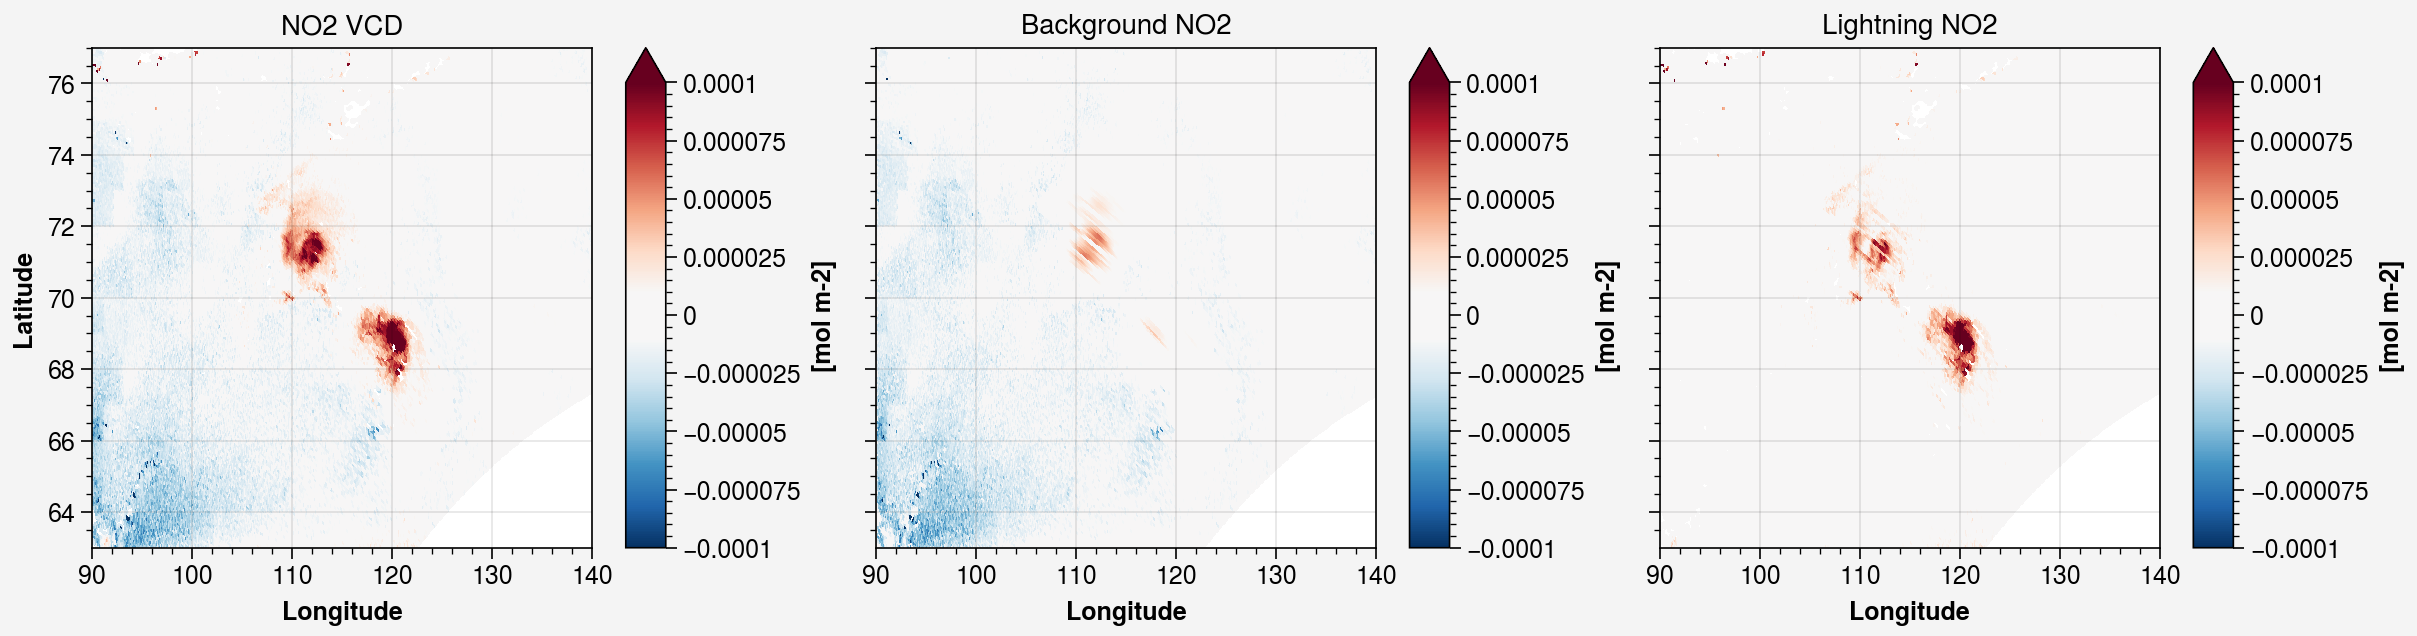

In [22]:
# test baseline_dwt
baseline = baseline_dwt(np.nan_to_num(no2, nan=np.nanmean(no2)), level=10, max_iter = 150)

fig, axs = pplt.subplots(ncols=3, spanx=0, spany=0)

lon, lat = no2.longitude, no2.latitude

m = axs[0].pcolormesh(lon, lat, no2, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[0].colorbar([m], label='[mol m-2]', extend='max')
axs[0].format(title='NO2 VCD')

m = axs[1].pcolormesh(lon, lat, baseline, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[1].colorbar([m], label='[mol m-2]', extend='max')
axs[1].format(title='Background NO2')

m = axs[2].pcolormesh(lon, lat, no2-baseline, discrete=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cmap_kw={'cut': -0.1})
axs[2].colorbar([m], label='[mol m-2]', extend='max')
axs[2].format(title='Lightning NO2')

axs.format(xlabel='Longitude', ylabel='Latitude', xlim=(90, 140), ylim=(63, 77))